3. Group Proposed Project (10 marks)
3.1 At this point, you understand the data quite well. Carry out the analysis you proposed
in your group project proposal. You should use the dataset given but you may also use
additional datasets to supplement your analysis, look at unaggregated data, etc. Please
be sure to justify why the analysis is useful and interesting in the context of a data science
project. Note that you are not limited to the initial proposal and are free to expand on
it.
3.2 Based on the insights derived from the analysis, suggest a practical action that can be
taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as
hyperparameter tuning here).

In [1]:
WINDOW_SIZE = 5
CLUSTER_COUNT = 30

In [2]:
import requests
import csv
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm


In [3]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Convert to datetime iso


def toIso(dt):
    return datetime.fromisoformat(dt)


def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(
            f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file):  # check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir, is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year, '/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
        # create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file
        df = pd.read_json(fDir)
        for heading in ("total_lots", "lot_type", "lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])

        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df

    def api_call_to_json(year, month, day, hour, minute, second):
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        return response_API, data

    fail_count = 0
    max_time_diff, time_diff = 25, 0
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)

    while not is_file_local and time_diff <= max_time_diff and fail_count < error_count:  # If file doesn't exist, api call
        new_min = str(int(minute) + time_diff)
        response_API, data = api_call_to_json(
            year, month, day, hour, new_min, new_min)

        # check if response is valid
        if response_API.ok and "items" in data and len(data["items"]) > 0 and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
            break
        elif time_diff < max_time_diff:
            time_diff += 1
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)
        else:
            fail_count += 1
            time_diff = 0
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)

    df = read_from_file(fDir)
    return df


# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"]


def addDayHour(df, day, hour):
    df["day"] = day
    df["hour"] = hour
    return df


def removeCountTotal(df):
    df = df.drop(columns=['lots_available', 'total_lots'])
    return df


In [4]:

carpark_rates_dir = f'./data/hdb-carpark-information.csv'
coord_df = pd.read_csv(carpark_rates_dir) 
coord_df[["car_park_no","x_coord","y_coord"]]

,car_park_no,x_coord,y_coord
0,ACB,30314.7936,31490.4942
1,ACM,33758.4143,33695.5198
2,AH1,29257.7203,34500.3599
3,AK19,28185.4359,39012.6664
4,AK31,29482.0290,38684.1754
...,...,...,...
2177,Y77M,29850.1522,45576.0125
2178,Y78M,30057.2209,45166.4820
2179,Y8,27772.9219,45686.2734
2180,Y82M,29935.5818,45679.7181


In [5]:
carparks = set()
location = dict()
for index,row in coord_df[["car_park_no","x_coord","y_coord"]].iterrows():
    carparks.add(row["car_park_no"])
    if row["car_park_no"] not in location:
        location[row["car_park_no"]] = [row["x_coord"],row["y_coord"]]
print(len(carparks),len(location))

2182 2182


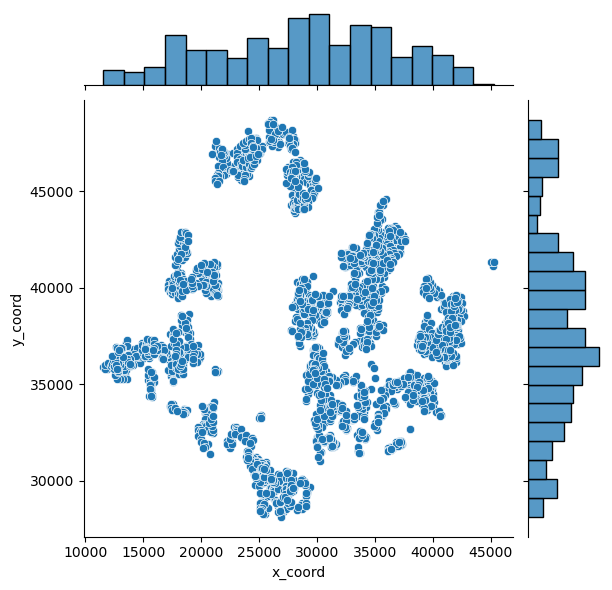

In [6]:
sns.jointplot(data=coord_df,x='x_coord',y='y_coord')

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

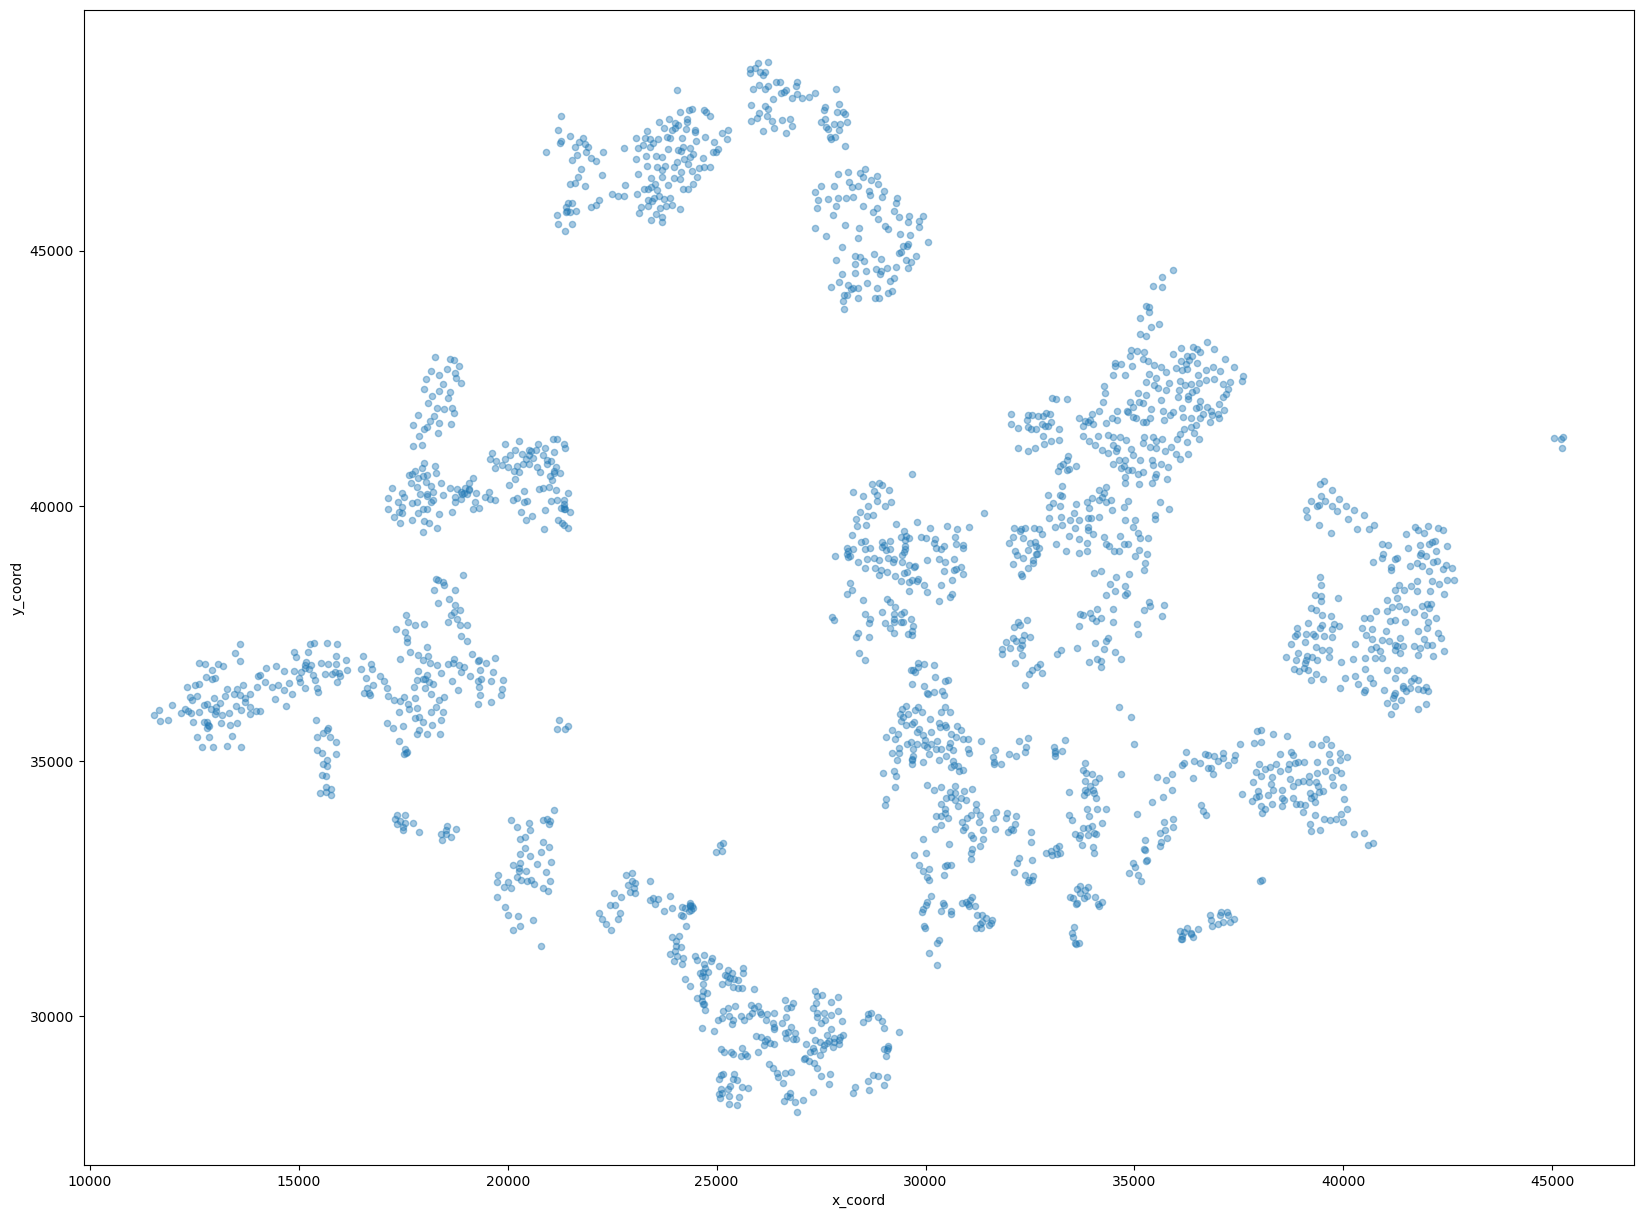

In [7]:
coord_df.plot(x="x_coord",y="y_coord",kind="scatter",alpha=0.4,figsize=(20,15))

Seperating the carparks into cluster by using k-means clustering

In [8]:
scaler = StandardScaler()
coord_df[["x_coord_T","y_coord_T"]] = scaler.fit_transform(coord_df[["x_coord","y_coord"]])

In [9]:
def optimise_k_means(data,max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

In [10]:
# optimise_k_means(coord_df[["x_coord_T","y_coord_T"]],50)

In [11]:
kmeans = KMeans(n_clusters=CLUSTER_COUNT,random_state = 1)
kmeans.fit(coord_df[["x_coord_T","y_coord_T"]])

KMeans(n_clusters=30, random_state=1)

In [12]:
coord_df["kmeans"] = kmeans.labels_
coord_df = coord_df[["car_park_no","x_coord","y_coord","kmeans"]]

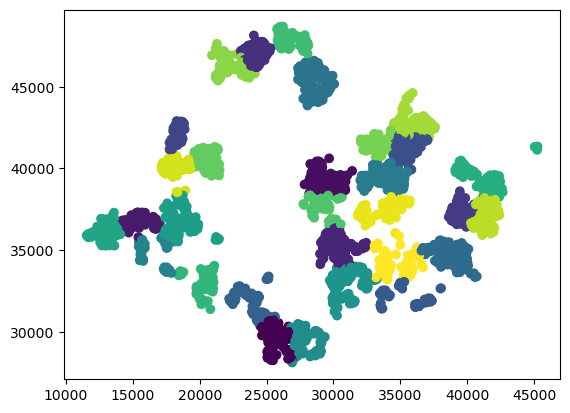

In [13]:
plt.scatter(x=coord_df["x_coord"],y=coord_df["y_coord"],c=coord_df["kmeans"])
plt.show()

In [14]:
def merge_on_col(df1,df2,col1,col2):
    return pd.merge(df1, df2, left_on=col1, right_on=col2, how='right').drop(col1, axis=1)

In [15]:
# start date 15 June 2022 0101

year = 2022
month = 6
day = 15
hour = 1
minute = 1
second = 1
ls=[]
datetime_df = datetime(year=year, month=month, day=day, hour=hour)
dt_interval = timedelta(hours = 1)
total_hrs = 24*7*19 #24 hours, 7 days a week, 19 weeks
clutster_dataframes = [[] for a in range(CLUSTER_COUNT)]
# day of week,time of day
train_x = []
# avalibility percentage
train_y = []
failed = []
for hr in tqdm(range(total_hrs)):
    try:
        datetime_df = datetime_df + dt_interval
        data = carparkApiCall(str(datetime_df.year), str(datetime_df.month), str(datetime_df.day), str(datetime_df.hour), str(datetime_df.minute), str(datetime_df.second), 5)
        new_df = merge_on_col(coord_df,data,"car_park_no","carpark_number")
        new_df1 = new_df.groupby(["kmeans"]).sum()
        new_df1['percentage_avalible'] = new_df1.apply(lambda row: row.lots_available/row.total_lots, axis=1)
        for cluster_no, row in new_df1.iterrows():
            clutster_dataframes[int(cluster_no)].append([datetime_df,row['percentage_avalible']])
    except:
        failed.append(datetime_df)
        continue
pdddd = pd.DataFrame(failed)


  0%|          | 0/3192 [00:00<?, ?it/s]

In [16]:
pdddd

""


In [17]:
def df_to_X_y(df, window_size=WINDOW_SIZE):
  df_as_np = df.to_numpy().flatten()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [18]:
def train_models(clutster_dataframes):
    best_models = []
    train_results,val_results,test_results = [],[],[]
    counter = 0
    for cluster in tqdm(clutster_dataframes):
        dff = pd.DataFrame(np.array(cluster),columns=["datetime","percentage"]).set_index("datetime")
        X1, y1 = df_to_X_y(dff, WINDOW_SIZE)
        length = len(X1)
        first,second = int(length*4/6),int(length-length/6)
        X_train1, y_train1 = X1[:first], y1[:first]
        X_val1, y_val1 = X1[first:second], y1[first:second]
        X_test1, y_test1 = X1[second:], y1[second:]
        
        best_models, train_results, val_results, test_results, counter = train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1)
        
        while mean_squared_error(test_results[-1]['Test Predictions'], test_results[-1]['Actuals']) > 0.001:
            test_results.pop()
            val_results.pop()
            train_results.pop()
            best_models.pop()
            best_models, train_results, val_results, test_results, counter = train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1)
            
    return train_results,val_results,test_results,best_models

def train_model(best_models, train_results, val_results, test_results, counter, X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1):
    model1 = Sequential()
    model1.add(InputLayer((WINDOW_SIZE, 1)))
    model1.add(LSTM(64))
    model1.add(Dense(8, 'relu'))
    model1.add(Dense(1, 'linear'))
        
    if counter == 0:
        print("shape(original):",X1.shape, y1.shape)
        print("shape(train,val,test):",X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)
        print(model1.summary())
        
    cp1 = ModelCheckpoint(f'model1/lstm{counter}.h5', save_best_only=True)        
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()])
    model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=200, callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor = 'val_mean_squared_error',
            min_delta=0.00001,
            patience = 10)
            ,cp1],verbose=0)
    
    model1 = load_model(f'model1/lstm{counter}.h5', compile=False)
    best_models.append(model1)
    counter+=1
        
    train_predictions = model1.predict(X_train1).flatten()
    train_results.append(pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1}))
        
    val_predictions = model1.predict(X_val1).flatten()
    val_results.append(pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1}))
        
    test_predictions = model1.predict(X_test1).flatten()
    test_results.append(pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1}))
    
    return best_models, train_results, val_results, test_results, counter
    

In [19]:
len(clutster_dataframes)

30

In [20]:
train_results,val_results,test_results,best_models = train_models(clutster_dataframes)

  0%|          | 0/30 [00:00<?, ?it/s]

shape(original): (3187, 5, 1) (3187,)
shape(train,val,test): (2124, 5, 1) (2124,) (531, 5, 1) (531,) (532, 5, 1) (532,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
None
17/17 [==============================] - 0s 3ms/step


mse: 0.00023303526307870713


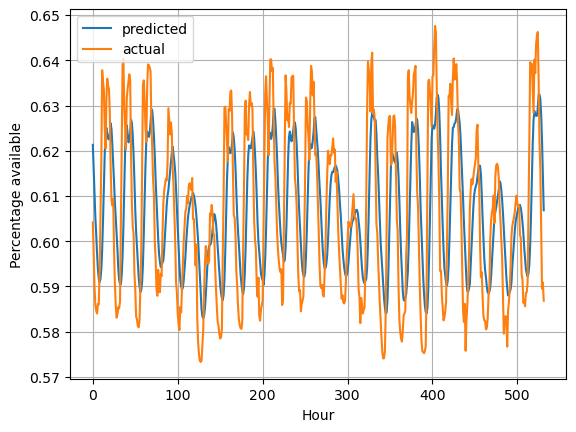

mse: 0.00039026210655263434


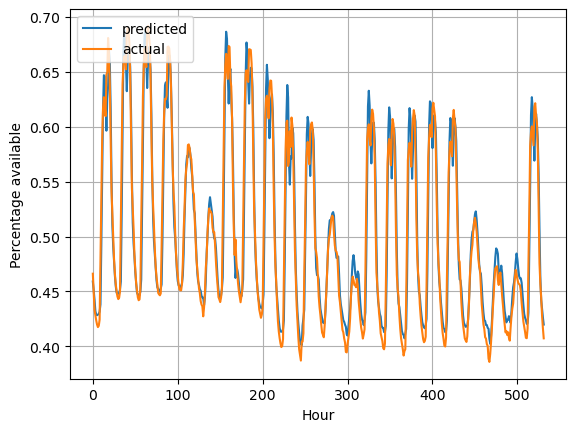

mse: 0.0003292217763795733


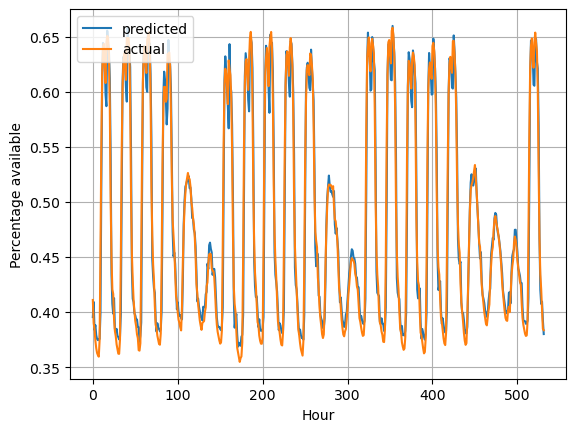

mse: 0.0002806297492686642


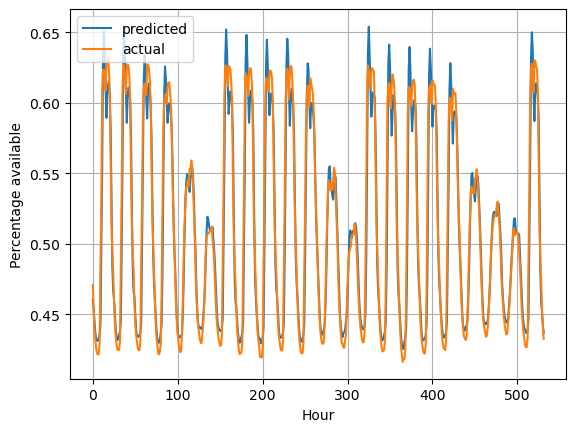

mse: 0.0004326542530876378


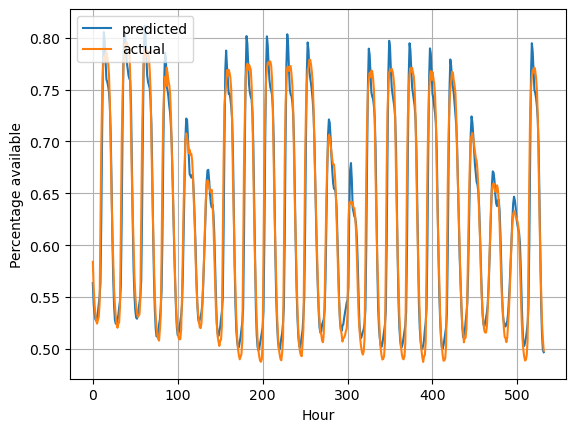

mse: 0.0004109223410550424


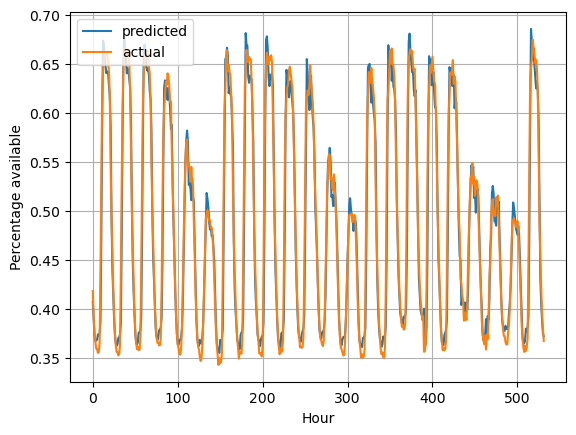

mse: 0.00040326626857437845


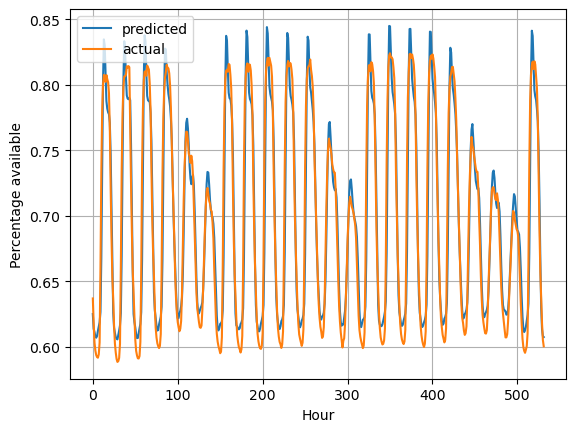

mse: 0.0003163166763276178


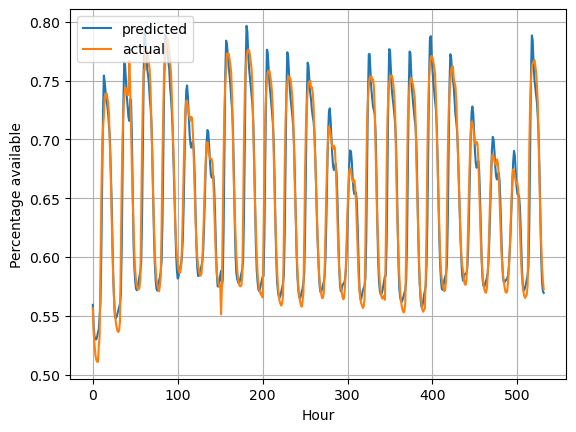

mse: 0.0005265558883501872


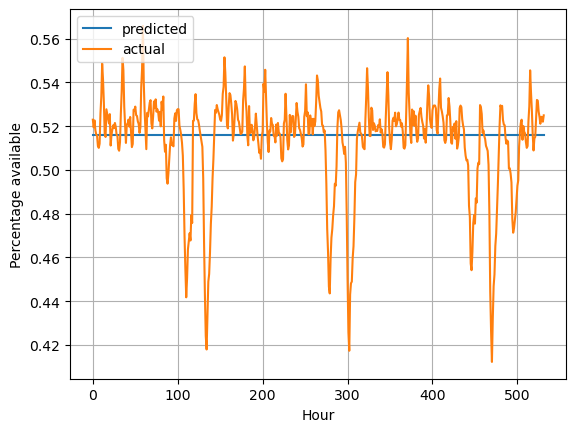

mse: 0.0004044156474803239


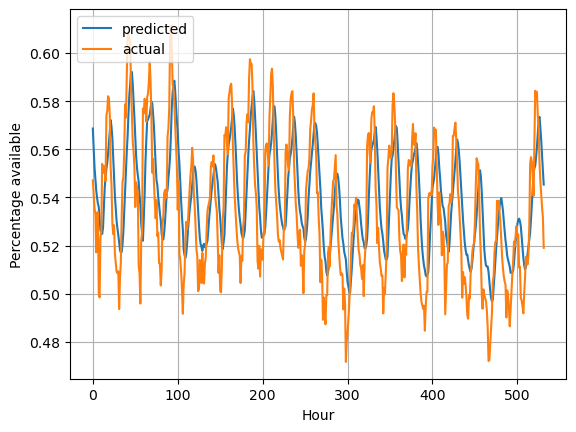

mse: 0.0003078638133562971


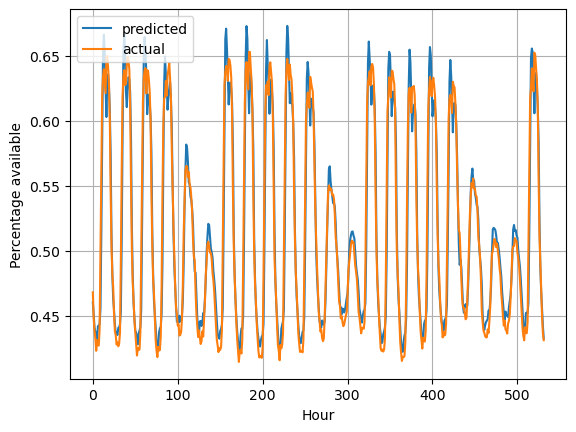

mse: 0.0003058461028079921


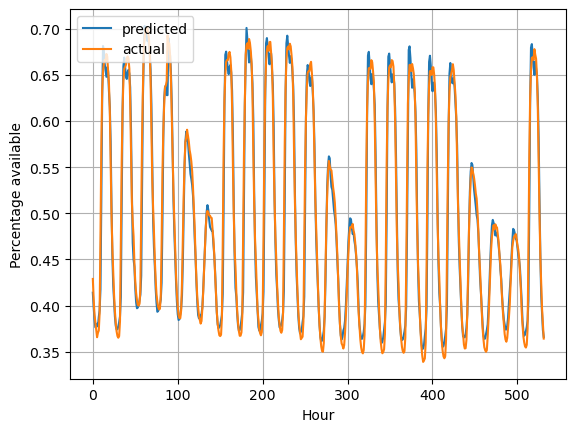

mse: 0.0003336635982166019


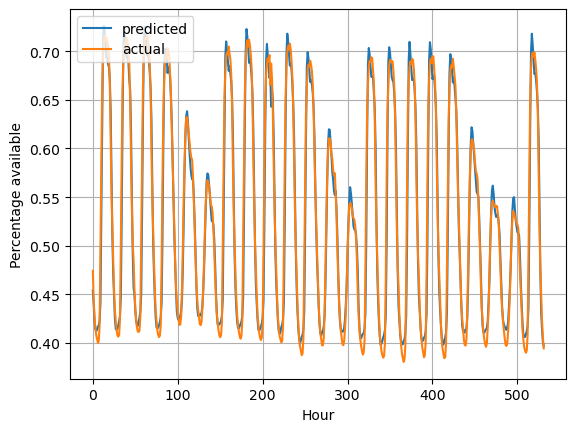

mse: 0.0005521730121833143


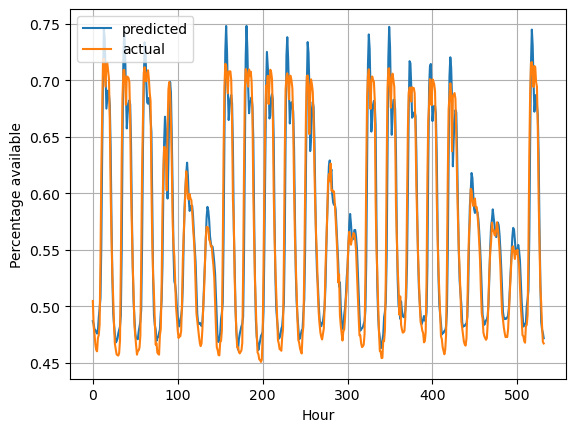

mse: 0.0005234142819601825


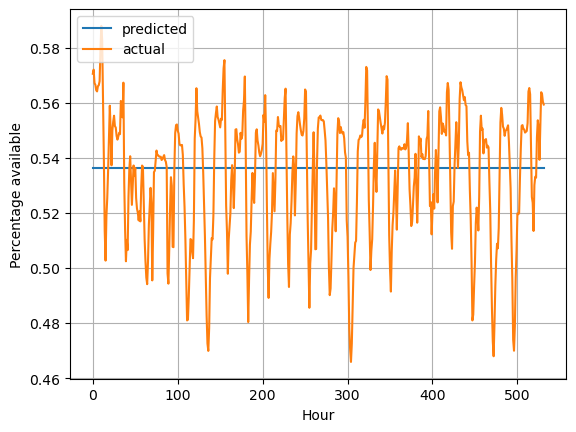

mse: 0.0002881033744037349


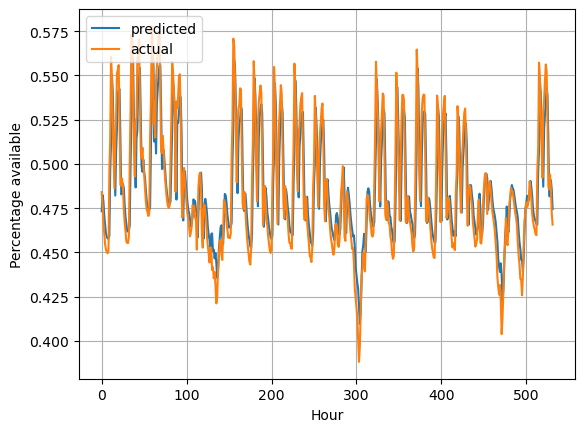

mse: 0.00034927490740170564


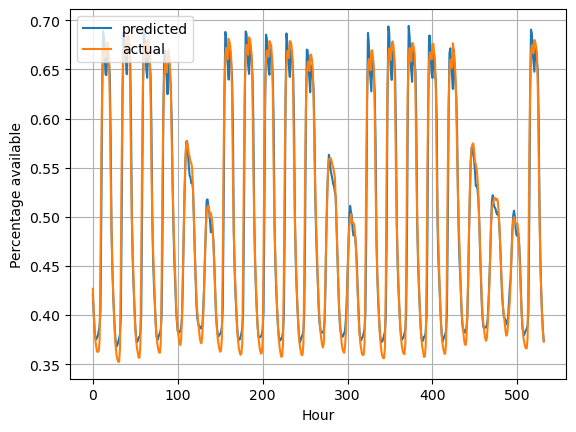

mse: 0.00047211098725181717


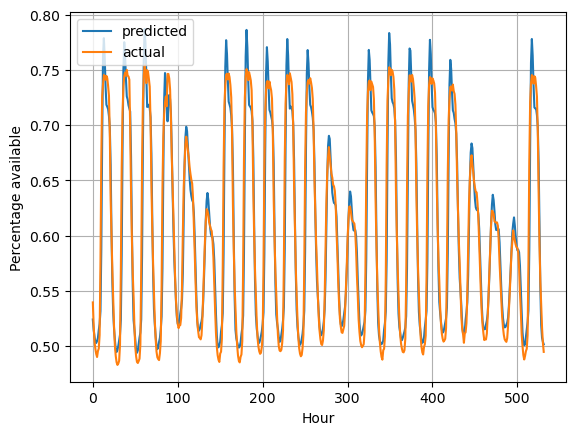

mse: 0.0004658285470349522


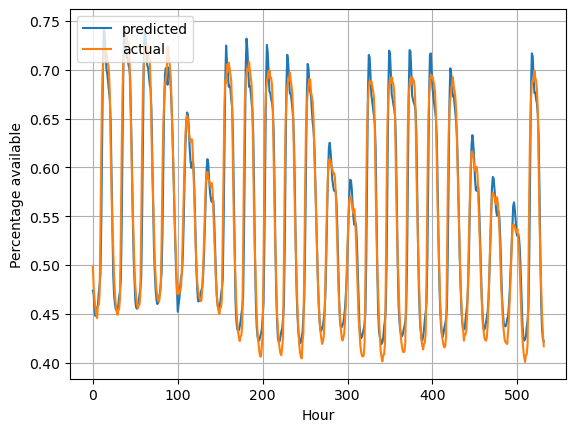

mse: 0.0007167346147205442


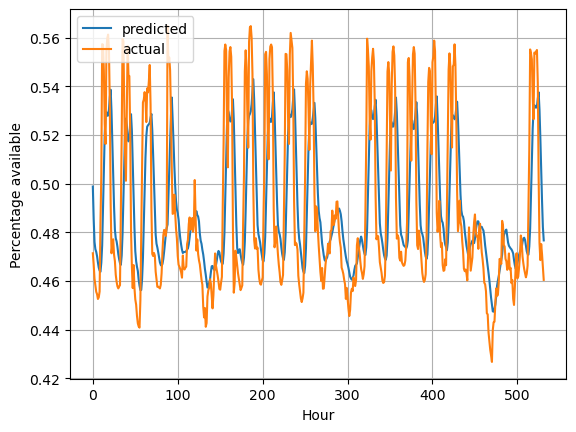

mse: 0.00043860102468923714


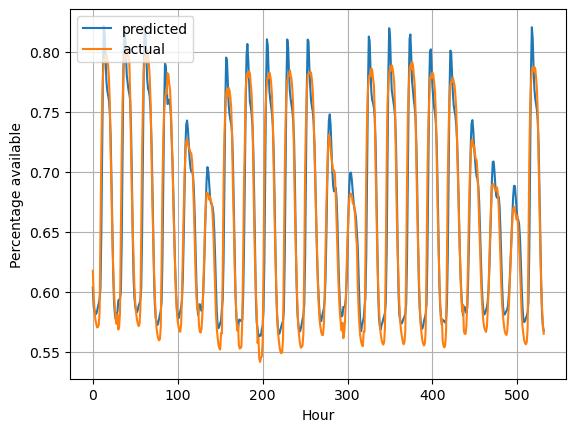

mse: 0.0003094973802372253


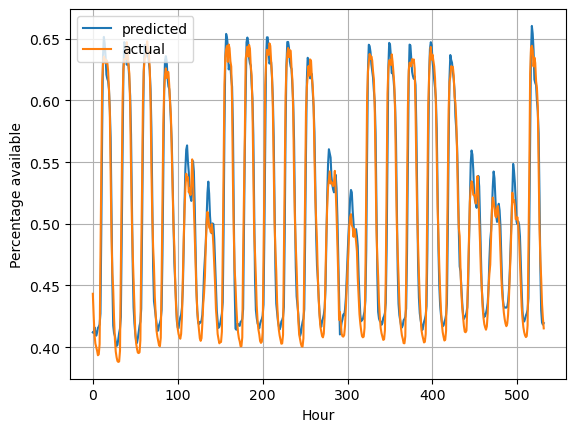

mse: 0.000749214761972081


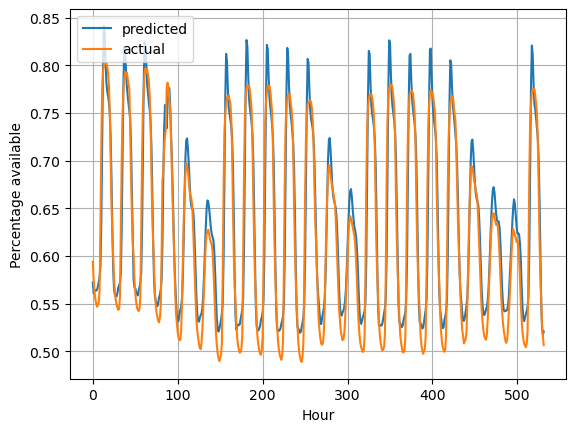

mse: 0.00023823158693415697


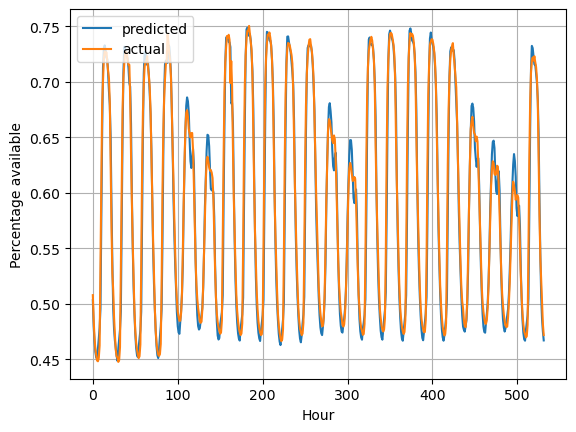

mse: 0.0003223744333287105


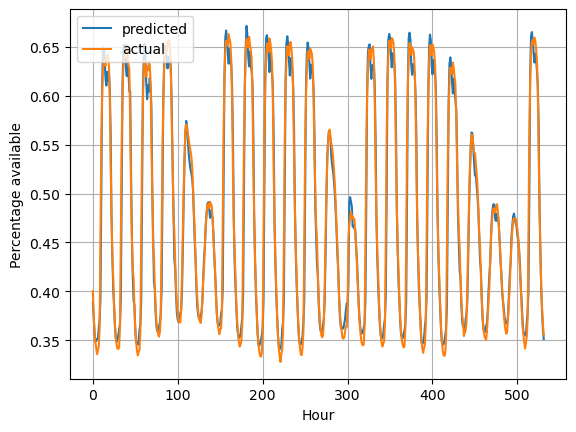

mse: 0.0003842990388029614


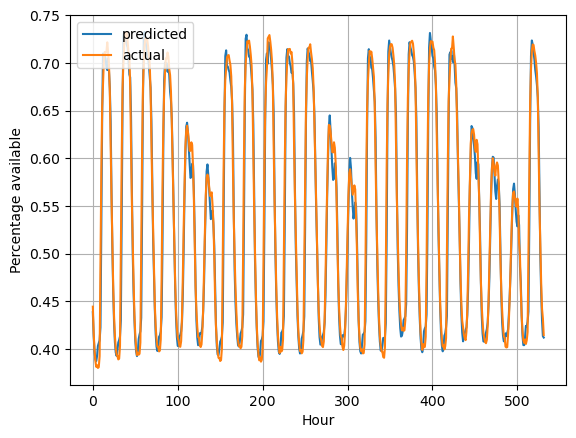

mse: 0.0003886588596709262


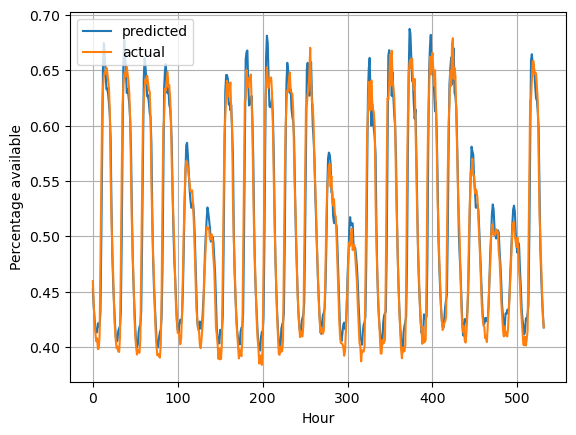

mse: 0.0003550533029268528


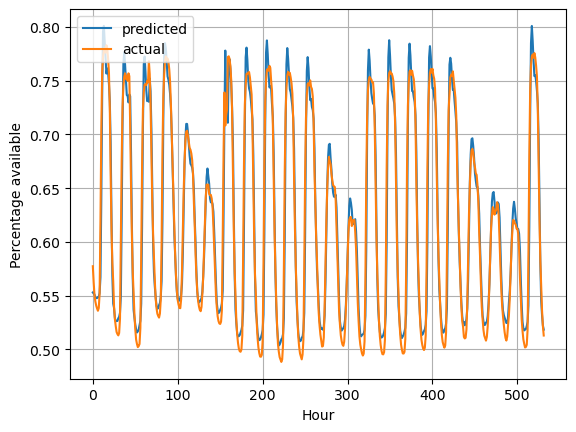

mse: 0.0003089067243064031


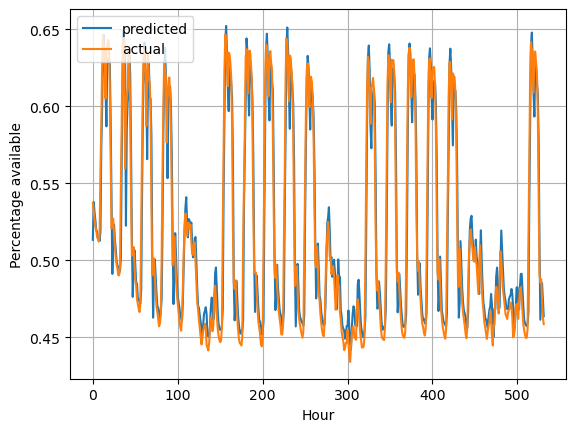

mse: 0.00021933484088607766


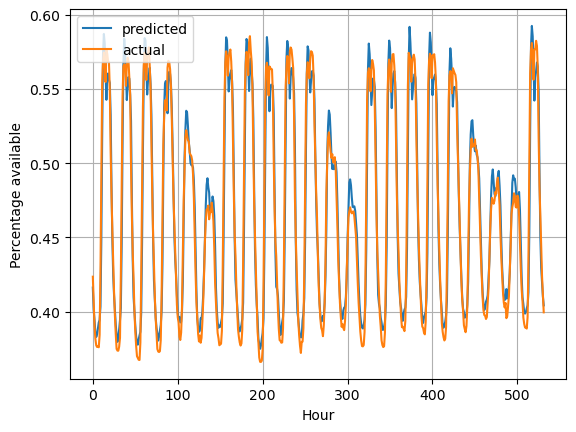

In [21]:
for i in range(len(test_results)):
    # plt.plot(train_results[i]['Train Predictions'])
    # plt.plot(train_results[i]['Actuals'])
    
    # plt.plot(val_results[i]['Val Predictions'])
    # plt.plot(val_results[i]['Actuals'])
    print(f"mse: {mean_squared_error(test_results[i]['Test Predictions'], test_results[i]['Actuals'])}")
    
    plt.plot(test_results[i]['Test Predictions'], label ='predicted')
    plt.plot(test_results[i]['Actuals'], label ='actual')
    
    plt.grid(True)
    plt.xlabel("Hour")
    plt.ylabel("Percentage available")
    plt.legend(loc='upper left')
    plt.show()

In [22]:
def plot(i):
    # plt.plot(train_results[i]['Train Predictions'])
    # plt.plot(train_results[i]['Actuals'])

    # plt.plot(val_results[i]['Val Predictions'])
    # plt.plot(val_results[i]['Actuals'])

    plt.plot(test_results[i]['Test Predictions'])
    plt.plot(test_results[i]['Actuals'])

In [23]:
# plot(2)